In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pomegranate import *
from pygraphviz import *
import seaborn as sns
from sklearn import model_selection, metrics

%matplotlib inline

### Чтение датасета и анализ

Для анализа предлагаются следующие данные. Полное описание датасета: https://www.bnlearn.com/documentation/man/insurance.html.

**Задачи:**
1. Необходимо выбрать часть переменных для построения сети.
2. Выбрать 2000-3000 наблюдений для ускорения вычислений (случайно или на основании каких-нибудь переменных).
3. Построить байесовскую сеть разными способами.
4. Сравнить полученные результаты.
5. Сравнить качество предсказаний по модели для переменной ThisCarCost - стоимость застрахованного автомобиля.


Загрузим датасет и выберем для исследования следующие признаки:


*   SocioEcon - социально-экономический статус;
*   RiskAversion - склонность избегать риск;
*   DrivQuality - качество вождения;
*   Accident - тяжесть несчастного случая;
*   CarValue - стоимость автомобиля;
*   ThisCarCost - расходы на застрахованный автомобиль.

In [ ]:
all_df = pd.read_csv("insurance.csv", dtype = str, 
                 usecols=['SocioEcon', 'DrivQuality', 'RiskAversion', 'CarValue', 'Accident', 'ThisCarCost'])
all_df.head()

,SocioEcon,RiskAversion,Accident,DrivQuality,ThisCarCost,CarValue
0,Prole,Adventurous,Mild,Poor,TenThou,FiveThou
1,Prole,Cautious,None,Normal,Thousand,TenThou
2,UpperMiddle,Psychopath,None,Excellent,Thousand,TwentyThou
3,Middle,Normal,None,Normal,Thousand,FiveThou
4,Prole,Normal,Moderate,Poor,TenThou,FiveThou


In [ ]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
SocioEcon       20000 non-null object
RiskAversion    20000 non-null object
Accident        20000 non-null object
DrivQuality     20000 non-null object
ThisCarCost     20000 non-null object
CarValue        20000 non-null object
dtypes: object(6)
memory usage: 937.6+ KB


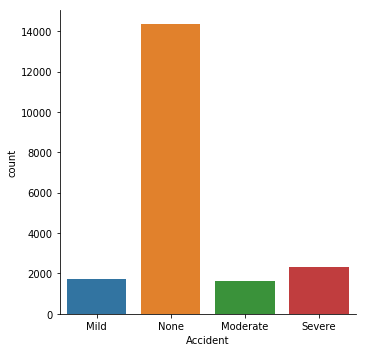

In [ ]:
sns.catplot(x="Accident", kind="count", data=all_df)

Все признаки категориальные, имеют 3-5 текстовых значений. В полном датасете 20000 записей без пропущенных значений и распределение значений Accident, представленное на рис. выше. Выбирая между этим признаком и SocioEcon, следует отметить, что преобладание наблюдений без происшествий (None) характерно для всех групп SocioEcon.

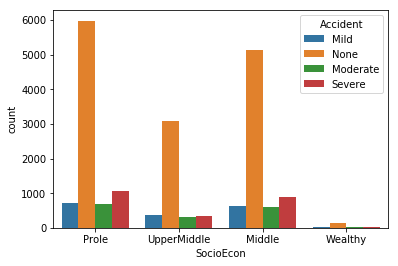

In [ ]:
sns.countplot(x='SocioEcon', hue='Accident', data=all_df)

### Выбор датасета

Так как интерес представляют ответы вероятностной модели в случаях происхождения несчастного случая, отберем из датасета записи со значениями Moderate (умеренная тяжесть) Severe (тяжелый несчастный случай).

In [ ]:
df = all_df.loc[(all_df['Accident'] == 'Moderate') | (all_df['Accident'] == 'Severe')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3926 entries, 4 to 19981
Data columns (total 6 columns):
SocioEcon       3926 non-null object
RiskAversion    3926 non-null object
Accident        3926 non-null object
DrivQuality     3926 non-null object
ThisCarCost     3926 non-null object
CarValue        3926 non-null object
dtypes: object(6)
memory usage: 214.7+ KB


В итоге получим 3926 наблюдений без пропущенных значений. Теперь необходимо разделить выборку на обучение и тест: 80% и 20%.

In [ ]:
X = df.drop(columns=['ThisCarCost'])
y = df['ThisCarCost']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [ ]:
train.head()

,SocioEcon,RiskAversion,Accident,DrivQuality,CarValue,ThisCarCost
5358,Prole,Normal,Moderate,Normal,FiveThou,TenThou
18764,Middle,Normal,Severe,Poor,FiveThou,TenThou
17384,Middle,Adventurous,Severe,Poor,FiveThou,TenThou
5681,Middle,Cautious,Moderate,Poor,TwentyThou,Thousand
2931,UpperMiddle,Adventurous,Severe,Poor,TwentyThou,HundredThou


На всякий случай проверим, что в каждую выборку попали представители всех классов, а значит у нас не возникнет трудностей в процессе. Но это читерство.

In [ ]:
train['ThisCarCost'].value_counts()

TenThou        1941
HundredThou     744
Thousand        445
Million          10
Name: ThisCarCost, dtype: int64

In [ ]:
test['ThisCarCost'].value_counts()

TenThou        484
HundredThou    189
Thousand       111
Million          2
Name: ThisCarCost, dtype: int64

### Построение БС № 1

Построим сеть с помощью первого наиболее простого алгоритма - exact-dp.

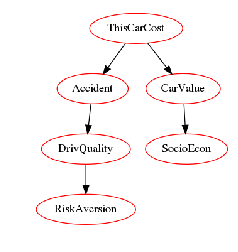

In [ ]:
bnet = BayesianNetwork.from_samples(train, algorithm='exact-dp')
bnet.bake()

colnames  = list(train)
for i in range(train.shape[1]):
    bnet.states[i].name = colnames[i]

bnet.plot() 

In [ ]:
bnet.predict_proba([[None, None, None, None, None, None]])[0][5].parameters

[{'Thousand': 0.1417197452229303,
  'TenThou': 0.6181528662420374,
  'HundredThou': 0.23694267515923567,
  'Million': 0.0031847133757968364}]

### Оценка качества структуры

Здесь и далее для оценки качества построенной структуры используем логарифм правдоподобие байесовской сети.

In [ ]:
bnet.log_probability(train.values.tolist()).sum()

-13900.439161427848

### Предсказания

Для дополнительной оценки на тестовой выборке используем точность предсказания модели и истинного значения переменной ThisCarCost.

In [ ]:
bnet.bake()

test_samples = pd.concat([X_test, pd.DataFrame([None]*test.shape[0])], axis=1)

for i in range(5):
    print("True:\t\t", test.iloc[i, -1])
    print("Prediction:\t", bnet.predict([test_samples.iloc[i, :].values.tolist()])[0][-1])
    print()

True:		 TenThou
Prediction:	 TenThou

True:		 TenThou
Prediction:	 TenThou

True:		 TenThou
Prediction:	 TenThou

True:		 Thousand
Prediction:	 TenThou

True:		 TenThou
Prediction:	 TenThou



In [ ]:
# Calculate accuracy between two lists
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual))

In [ ]:
truly = y_test.values.tolist()
preds = []

for i in range(test.shape[0]):
    preds.append(bnet.predict([test_samples.iloc[i, :].values.tolist()])[0][-1])

accuracy_metric(truly, preds)

0.6170483460559797

Видим довольно низкую точность и подозрительно одинаковые ответы модели на тестовом примере. Посмотрим на соотношение всех данных моделью предсказаний.

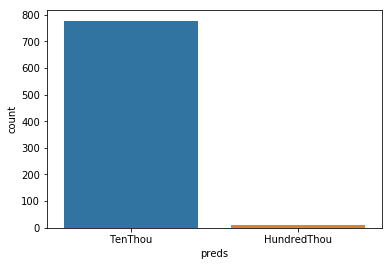

In [ ]:
preds_df = pd.DataFrame(preds)
preds_df.columns = ['preds']
sns.countplot(x='preds', data=preds_df)

Видим, что модель на 20% всей выборки дала только 2 ответа, причем один из классов значительно преобладает. Это объясняется сильной несбалансированностью вероятностей, данных моделью. Если вернутся выше и вновь посмотреть на результат вывода predict_proba, видно, что именно такой дисбаланс наблюдается и в данный моделью вероятностях событий.

### Построение БС №2

Попробуем другой алгоритм - chow-liu. Этот метод известен тем, что выполняет более приближенное построение структуры за счет того, что строит древовидные сети (т.е. у каждого фактора модели может быть только один родитель).

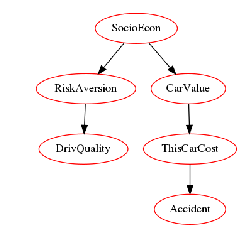

In [ ]:
bnet2 = BayesianNetwork.from_samples(train, algorithm='chow-liu')
bnet2.bake()

colnames  = list(train)
for i in range(train.shape[1]):
    bnet2.states[i].name = colnames[i]

bnet2.plot() 

In [ ]:
bnet2.predict_proba([[None, None, None, None, None, None]])[0][5].parameters

[{'TenThou': 0.6181528662420369,
  'Thousand': 0.1417197452229301,
  'Million': 0.0031847133757969843,
  'HundredThou': 0.23694267515923595}]

Кажется, что структура сети поменялась, однако взаимосвязи между факторами остались теми же, точно так же, как предсказываемые вероятности.

### Оценка качества структуры № 2

In [ ]:
bnet2.log_probability(train.values.tolist()).sum()

-13875.359323292669

Правдоподобие модели немного улучшилось.

### Предсказания

In [ ]:
bnet2.bake()
    
preds2 = []
for i in range(test.shape[0]):
    preds2.append(bnet2.predict([test_samples.iloc[i, :].values.tolist()])[0][-1])

accuracy_metric(truly, preds2)

0.6170483460559797

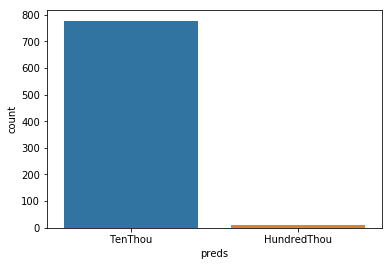

In [ ]:
preds_df2 = pd.DataFrame(preds2)
preds_df2.columns = ['preds']
sns.countplot(x='preds', data=preds_df2)

Распределение ответов модели осталось неизменным, как и значение точности. Впрочем, это ожидаемый результат с теми же вероятностями.

### Построене БС № 3

Перепроверим структуру на устойчивость и построим байесовскую сеть жадным алгоритмом. 

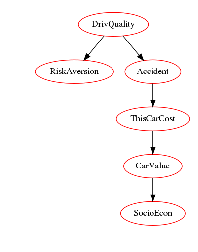

In [ ]:
bnet3 = BayesianNetwork.from_samples(train, algorithm='greedy')
bnet3.bake()

colnames  = list(train)
for i in range(train.shape[1]):
    bnet3.states[i].name = colnames[i]

bnet3.plot() 

In [ ]:
bnet3.bake()
bnet3.predict_proba([[None, None, None, None, None, None]])[0][5].parameters

[{'TenThou': 0.6181528662420376,
  'Thousand': 0.14171974522293018,
  'HundredThou': 0.23694267515923575,
  'Million': 0.0031847133757966157}]

Обратим внимание, что структура сильно изменилась - взаимосвязи факторов поменялись. Посмотрим, повлияет ли это на результат предсказаний.

### Оценка качества структуры № 3

In [ ]:
bnet3.log_probability(train.values.tolist()).sum()

-13900.439161427848

Обидно, качество снова ухудшилось.

### Предсказания

In [ ]:
preds3 = []
for i in range(test.shape[0]):
    bnet3.bake()
    preds3.append(bnet3.predict([test_samples.iloc[i, :].values.tolist()])[0][-1])

accuracy_metric(truly, preds3)

0.6170483460559797

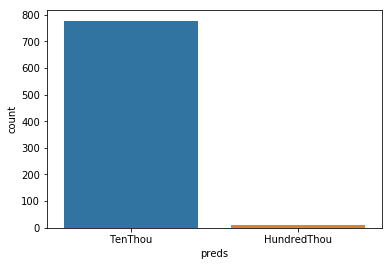

In [ ]:
preds_df3 = pd.DataFrame(preds3)
preds_df3.columns = ['preds']
sns.countplot(x='preds', data=preds_df3)

И ответы остались теми же. 


Полученные модели, хоть и имеют отличные структуры, на статистических данных дают одни и те же априорные распределения для расходов на застрахованный автомобиль. Из этого следует и одинаковость предсказаний и значений точности. Такое единогласное предсказание лишний раз подтверждает вариативность и неоднозначность возможных структур взаимосвязей факторов модели. Данный пример наглядно показал, как даже отличающиеся структуры могут давать ярко выраженные ответы за счет сильного расхождения априорных вероятностей. Вероятно, в более интересном случае с вероятностями близкими к 0.5 удалось бы получить больше спорных случаев. 

В качестве путей к этим "более интересным" случаям можно предложить выбор других переменных с менее очевидными взаимосвязями. В реальном кейсе можно было бы привлечь экспертов и ввестие дополнительные разумные ограничения на структуру сети. Это позволило бы модели получить оптимальную и разумную интерпретацию и,возможно, лучшую предсказательную способность.

Однако экспертную оценку в данном случае подключать нет возможности, поэтому лидера можно определить лишь формально основываясь на метрике правдоподобия. Тогда предпочтительной моделью становится байесовская сеть, построенная методом chow-liu.

Основываясь на данной модели, можно заключить, что социально-экономический статус водителя влияет на склонность избегать риски и на стоимость автомобиля. Наличие тяги к риску воздействует на качество вождения, а стоимость автомобиля, в свою очередь, оказывает влияние на расходы страховки. До этого момента все звучит логично с точки зрения здравого смысла, однако на финише сеть устанавливает, что расходы на застрахованный автомобиль влияют на тяжесть несчастного случая, что сомнительно. В этом случае, ручна корректировка ограничений на связи в графе сыграла бы лучшую роль.